In [1]:
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 

In [24]:
# events with 10mm displacement
fname_10mm="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod_ctau-10.root"
events_10mm = NanoEvents.from_file(fname_10mm,methods={"ElectronBPark":Electron})

#events with 1mm displacement
fname_1mm="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod.root"
events_1mm = NanoEvents.from_file(fname_1mm,methods={"ElectronBPark":Electron})

In [60]:
# event level MET-Jet cut
def MET_Jet_cut (events): 
    return events [
        (events.MET.pt >120)
        & (events.Jet.pt.max() > 80)
    ]

soft_eles_1mm = MET_Jet_cut(events_1mm).ElectronBPark
soft_eles_10mm = MET_Jet_cut(events_10mm).ElectronBPark

# recquirement for matched gen electrons
# as a cut
def matched_gen_cut (electrons):
    return electrons [
        (abs(electrons.matched_gen.pdgId) == 11) 
               & (electrons.matched_gen.parent.pdgId == 1000023)
               & (electrons.matched_gen.status == 1) 
               & (electrons.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"]))
    ]
# as a mask
def matched_gen_mask (electrons):
    return ((abs(electrons.matched_gen.pdgId) == 11) 
               & (electrons.matched_gen.parent.pdgId == 1000023)
               & (electrons.matched_gen.status == 1) 
               & (electrons.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"])))

def gen_part_cut (genpart):
    return genpart [
        (abs(genpart.pdgId) == 11) 
               & (genpart.parent.pdgId == 1000023)
               & (genpart.status == 1) 
               & (genpart.hasFlags(["fromHardProcess", "isFirstCopy"]))
    ]

all_gen_eles_1mm = gen_part_cut(MET_Jet_cut(events_1mm).GenPart)
all_gen_eles_10mm = gen_part_cut(MET_Jet_cut(events_10mm).GenPart)


# for both matched and unmatched electrons I exclude PF electrons since they don't produce
# electrons with pt<5GeV
matched_eles_1mm = matched_gen_cut(soft_eles_1mm[soft_eles_1mm.isPF==False])
matched_eles_10mm = matched_gen_cut(soft_eles_10mm[soft_eles_10mm.isPF==False])

# Note that there are two categories of unmatched electrons
#
# 1. Fake electrons
# 2. Real electrons that were produced in a jet or from pileup
# Category 1 corresponds to matched_gen == None
# Category 2 corresponds to an existing matched_gen but eg. matched_gen.parent.pdgId doesn’t equal 100023
# below I'm counting both categroies as fakes
# fill the None's with false

unmatched_eles_1mm = soft_eles_1mm[(~(matched_gen_mask(soft_eles_1mm).fillna(False))) 
                                   & (soft_eles_1mm.isPF == False)]
unmatched_eles_10mm = soft_eles_10mm[(~(matched_gen_mask(soft_eles_10mm).fillna(False))) 
                                   & (soft_eles_10mm.isPF == False)]

In [61]:
def cut_pt(electrons):
    return electrons[
        (electrons.pt<5) 
        & (electrons.pt>1)
    ]
print("The number of matched electrons with 1<pt<5 GeV with cTau=1mm:")
print(len(cut_pt(matched_eles_1mm).flatten()))
print("The number of matched electrons with 1<pt<5 GeV with cTau=10mm:")
print(len(cut_pt(matched_eles_10mm).flatten()))

The number of matched electrons with 1<pt<5 GeV with cTau=1mm:
434
The number of matched electrons with 1<pt<5 GeV with cTau=10mm:
266


In [110]:
# I have examined both samples separately and have come up with different cuts for each

def cut_1mm(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 0.5)
        & (electrons.sip3d < 100)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d > 0.2)
        & (electrons.mvaId > 1.3)
        & (abs(electrons.dz) < 0.25)
         & (abs(electrons.dxy) < 0.3)
         & (electrons.ptBiased > 0.5)
    ]
def cut_10mm(electrons):
    return electrons[
        (electrons.pt > 1) & (electrons.pt<5)
        & (electrons.ip3d < 2.5)
        & (electrons.ip3d > 0.02)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d < 200)
        & (electrons.sip3d > 0.2)
        & (electrons.mvaId > 1.2)
        & (abs(electrons.dz) < 2)
         & (abs(electrons.dxy) < 1)
         & (electrons.ptBiased > 0.5)
    ]

def cut_combined (electrons):
    return electrons[
        (electrons.pt>1) & (electrons.pt<5)
        & (electrons.mvaId > 1.3)
        & (electrons.ptBiased > 0.5)
        & (electrons.fBrem > -1.9)
        & (electrons.sip3d > 0.2)
        & (electrons.sip3d <200)
        & (electrons.ip3d < 2.5)
        & (abs(electrons.dxy) < 1) 
        & (abs(electrons.dz) < 1.8)
        & (electrons.ip3d > 0.01) 
    ]
print("Number of matched electrons passing cut_1mm for cTau=1mm:")
print(len(cut_1mm(matched_eles_1mm).flatten()))
print("Number of matched electrons passing cut_10mm for cTau=10mm:")
print(len(cut_10mm(matched_eles_10mm).flatten()))
print("Number of matched electrons passing cut_combined for cTau=1mm:")
print(len(cut_combined(matched_eles_1mm).flatten()))
print("Number of matched electrons passing cut_combined for cTau=10mm:")
print(len(cut_combined(matched_eles_10mm).flatten()))

Number of matched electrons passing cut_1mm for cTau=1mm:
272
Number of matched electrons passing cut_10mm for cTau=10mm:
167
Number of matched electrons passing cut_combined for cTau=1mm:
280
Number of matched electrons passing cut_combined for cTau=10mm:
164


In [111]:
#
# Note that in the function below I'm counting both above mentioned categories as fakes
#
import operator
# calculates the number of fakes per event
# parameter "electrons": jagged array of events
# paramter "good_cut": cut on electrons
# parameter "matched_mask": matching mask related to soft_eles
# output: returns a list containing the umber of fakes per event
def numfakes(electrons, good_cut, matched_cut, pf_mask):
    x=[]
    for i in good_cut(electrons[pf_mask]):
        x.append(len(i))
    y=[]
    for i in good_cut(matched_cut(electrons[pf_mask])):
        y.append(len(i))
    return list(map(operator.sub, x, y))

The avg. number of fakes per event for cTau=1mm (with cut_1mm):
0.8955431754874652
The avg. number of fakes per event for cTau=1mm (with cut_combined):
1.1455431754874652
Then avg. number of fakes per event for cTau=1mm (with cut_pt):
40.98398328690808


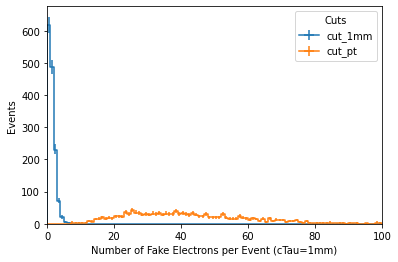

In [112]:
histo_numfakes_1mm= hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("numfakes", "Number of Fake Electrons per Event (cTau=1mm)", 100, 0, 100),
        )

#histo_numfakes.fill(cuts="no_cut", numfakes = np.array(numfakes(soft_eles, cuttest, matched_mask, (soft_eles.isPF == False))))
histo_numfakes_1mm.fill(cuts="cut_pt", numfakes = np.array(numfakes(soft_eles_1mm, cut_pt, matched_gen_cut, (soft_eles_1mm.isPF == False))))
histo_numfakes_1mm.fill(cuts="cut_1mm", numfakes = np.array(numfakes(soft_eles_1mm, cut_1mm, matched_gen_cut, (soft_eles_1mm.isPF == False))))

#
# Note that when calculating the average number of fakes per event I'm also taking into account
# events with zero truth and fake electrons.
#
print("The avg. number of fakes per event for cTau=1mm (with cut_1mm):")
print(sum(numfakes(soft_eles_1mm, cut_1mm, matched_gen_cut, (soft_eles_1mm.isPF == False)))/len(numfakes(soft_eles_1mm, cut_1mm, matched_gen_cut, (soft_eles_1mm.isPF == False))))
print("The avg. number of fakes per event for cTau=1mm (with cut_combined):")
print(sum(numfakes(soft_eles_1mm, cut_combined, matched_gen_cut, (soft_eles_1mm.isPF == False)))/len(numfakes(soft_eles_1mm, cut_combined, matched_gen_cut, (soft_eles_1mm.isPF == False))))
print("Then avg. number of fakes per event for cTau=1mm (with cut_pt):")
print(sum(numfakes(soft_eles_1mm, cut_pt, matched_gen_cut, (soft_eles_1mm.isPF == False)))/len(numfakes(soft_eles_1mm, cut_pt, matched_gen_cut, (soft_eles_1mm.isPF == False))))
hist.plot1d(histo_numfakes_1mm)

The avg. number of fakes per event for cTau=10mm (with cut_10mm):
0.9459279038718291
The avg. number of fakes per event for cTau=10mm (with cut_combined):
0.8437917222963952
Then avg. number of fakes per event for cTau=10mm (with cut_pt):
41.649532710280376


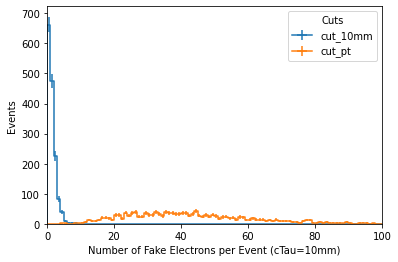

In [109]:
histo_numfakes_10mm= hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("numfakes", "Number of Fake Electrons per Event (cTau=10mm)", 100, 0, 100),
        )

#histo_numfakes.fill(cuts="no_cut", numfakes = np.array(numfakes(soft_eles, cuttest, matched_mask, (soft_eles.isPF == False))))
histo_numfakes_10mm.fill(cuts="cut_pt", numfakes = np.array(numfakes(soft_eles_10mm, cut_pt, matched_gen_cut, (soft_eles_10mm.isPF == False))))
histo_numfakes_10mm.fill(cuts="cut_10mm", numfakes = np.array(numfakes(soft_eles_10mm, cut_10mm, matched_gen_cut, (soft_eles_10mm.isPF == False))))

#
# Note that when calculating the average number of fakes per event I'm also taking into account
# events with zero truth and fake electrons.
#
print("The avg. number of fakes per event for cTau=10mm (with cut_10mm):")
print(sum(numfakes(soft_eles_10mm, cut_10mm, matched_gen_cut, (soft_eles_10mm.isPF == False)))/len(numfakes(soft_eles_10mm, cut_10mm, matched_gen_cut, (soft_eles_10mm.isPF == False))))
print("The avg. number of fakes per event for cTau=10mm (with cut_combined):")
print(sum(numfakes(soft_eles_10mm, cut_combined, matched_gen_cut, (soft_eles_10mm.isPF == False)))/len(numfakes(soft_eles_10mm, cut_combined, matched_gen_cut, (soft_eles_10mm.isPF == False))))
print("Then avg. number of fakes per event for cTau=10mm (with cut_pt):")
print(sum(numfakes(soft_eles_10mm, cut_pt, matched_gen_cut, (soft_eles_10mm.isPF == False)))/len(numfakes(soft_eles_10mm, cut_pt, matched_gen_cut, (soft_eles_10mm.isPF == False))))
hist.plot1d(histo_numfakes_10mm)

(-0.5, 0.5)

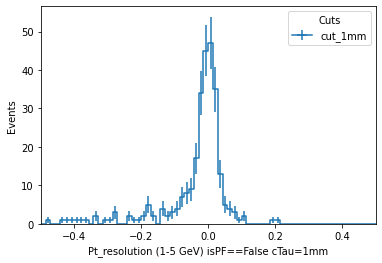

In [99]:
# pt resolution curve for 1-5 GeV cTau=1mm

flat_eles_1mm = cut_1mm(matched_eles_1mm).flatten()
pt_reso_cut_1mm = (flat_eles_1mm.pt - flat_eles_1mm.matched_gen.pt) / (flat_eles_1mm.matched_gen.pt)

histo_pt_reso_1mm = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (1-5 GeV) isPF==False cTau=1mm", 70, -0.5, 0.5),
        )
histo_pt_reso_1mm.fill(cuts = "cut_1mm", pt_reso = np.array(pt_reso_cut_1mm))

ax_pt_reso_1mm = hist.plot1d(histo_pt_reso_1mm, overflow = "all")
ax_pt_reso_1mm.set_xlim(right=0.5, left=-0.5)


(-0.5, 0.5)

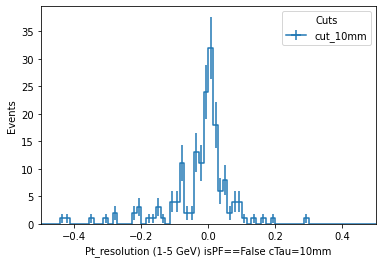

In [100]:
# pt resolution curve for 1-5 GeV cTau=10mm

flat_eles_10mm = cut_10mm(matched_eles_10mm).flatten()
pt_reso_cut_10mm = (flat_eles_10mm.pt - flat_eles_10mm.matched_gen.pt) / (flat_eles_10mm.matched_gen.pt)

histo_pt_reso_10mm = hist.Hist(
            "Events",
            hist.Cat("cuts", "Cuts"),
            hist.Bin("pt_reso", "Pt_resolution (1-5 GeV) isPF==False cTau=10mm", 70, -0.5, 0.5),
        )
histo_pt_reso_10mm.fill(cuts = "cut_10mm", pt_reso = np.array(pt_reso_cut_10mm))

ax_pt_reso_10mm = hist.plot1d(histo_pt_reso_10mm, overflow = "all")
ax_pt_reso_10mm.set_xlim(right=0.5, left=-0.5)

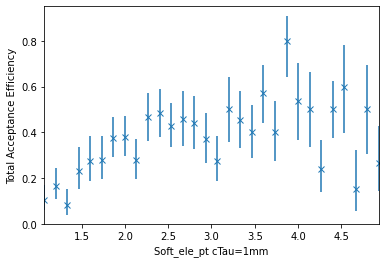

In [68]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all_1mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cTau=1mm", 30, 1, 5),
        )

histo_all_1mm.fill(variables="denominator", soft_ele = cut_pt(matched_eles_1mm).pt.flatten())

#total acceptance efficiency cruve
histo_all_genele_1mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Gen_ele_pt cTau=1mm", 30, 1, 5),
        )
histo_eff_cut_1mm = hist.Hist(
            "Total Acceptance Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cTau=1mm", 30, 1, 5),
        )
histo_eff_cut_1mm.fill(variables="looseMVA", soft_ele = cut_1mm(matched_eles_1mm).pt.flatten())
histo_all_genele_1mm.fill(variables="denominator", soft_ele = cut_pt(all_gen_eles_1mm).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut_1mm.integrate("variables"), denom=histo_all_genele_1mm.integrate("variables"), error_opts={"marker": "x"})

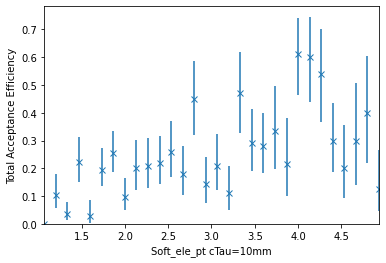

In [69]:
#----------------------------------------------------------------------------
# pt efficiency curves
#----------------------------------------------------------------------------
histo_all_10mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cTau=10mm", 30, 1, 5),
        )

histo_all_10mm.fill(variables="denominator", soft_ele = cut_pt(matched_eles_10mm).pt.flatten())

#total acceptance efficiency cruve
histo_all_genele_10mm = hist.Hist(
            "All",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Gen_ele_pt cTau=10mm", 30, 1, 5),
        )
histo_eff_cut_10mm = hist.Hist(
            "Total Acceptance Efficiency",
            hist.Cat("variables", "Variables"),
            hist.Bin("soft_ele", "Soft_ele_pt cTau=10mm", 30, 1, 5),
        )
histo_eff_cut_10mm.fill(variables="looseMVA", soft_ele = cut_10mm(matched_eles_10mm).pt.flatten())
histo_all_genele_10mm.fill(variables="denominator", soft_ele = cut_pt(all_gen_eles_10mm).pt.flatten())

%matplotlib inline
hist.plotratio(num=histo_eff_cut_10mm.integrate("variables"), denom=histo_all_genele_10mm.integrate("variables"), error_opts={"marker": "x"})

(-1.4, 1.4)

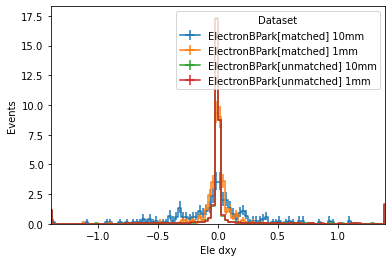

In [70]:
histo_dxy = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dxy", "Ele dxy", 100, -1.39, 1.39),
        )
histo_dxy.fill(dataset ="ElectronBPark[matched] 1mm", dxy = cut_pt(matched_eles_1mm).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[unmatched] 1mm", dxy = cut_pt(unmatched_eles_1mm).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[matched] 10mm", dxy = cut_pt(matched_eles_10mm).dxy.flatten())
histo_dxy.fill(dataset ="ElectronBPark[unmatched] 10mm", dxy = cut_pt(unmatched_eles_10mm).dxy.flatten())
%matplotlib inline
ax_dxy = hist.plot1d(histo_dxy, density = True, overflow="all")
ax_dxy.set_xlim(right=1.4, left=-1.4)

(-20.0, 20.0)

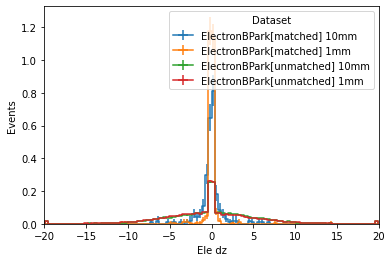

In [72]:
histo_dz = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("dz", "Ele dz", 100, -19.5, 19.5),
        )
histo_dz.fill(dataset ="ElectronBPark[matched] 1mm", dz = cut_pt(matched_eles_1mm).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[unmatched] 1mm", dz = cut_pt(unmatched_eles_1mm).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[matched] 10mm", dz = cut_pt(matched_eles_10mm).dz.flatten())
histo_dz.fill(dataset ="ElectronBPark[unmatched] 10mm", dz = cut_pt(unmatched_eles_10mm).dz.flatten())
%matplotlib inline
ax_dz = hist.plot1d(histo_dz, density = True, overflow="all")
ax_dz.set_xlim(right=20, left=-20)

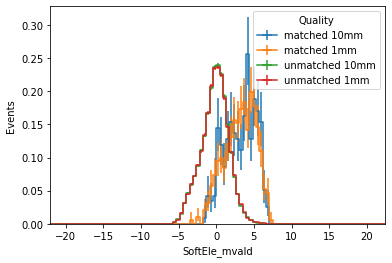

In [73]:
histo_mvaId = hist.Hist(
            "Events ",
            hist.Cat("quality", "Quality"),
            hist.Bin("soft_unmatched_ele", "SoftEle_mvaId", 100, -22, 22),
        )

histo_mvaId.fill(quality ="matched 1mm", soft_unmatched_ele=cut_pt(matched_eles_1mm).mvaId.flatten())
histo_mvaId.fill(quality ="unmatched 1mm", soft_unmatched_ele=cut_pt(unmatched_eles_1mm).mvaId.flatten())
histo_mvaId.fill(quality ="matched 10mm", soft_unmatched_ele=cut_pt(matched_eles_10mm).mvaId.flatten())
histo_mvaId.fill(quality ="unmatched 10mm", soft_unmatched_ele=cut_pt(unmatched_eles_10mm).mvaId.flatten())


%matplotlib inline
hist.plot1d(histo_mvaId, overflow = "over", density = True)

(0.0, 700.0)

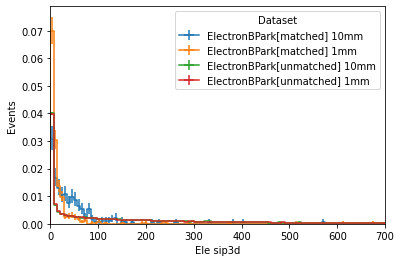

In [74]:
histo_sip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("sip3d", "Ele sip3d", 100, 0, 700),
        )
histo_sip3d.fill(dataset ="ElectronBPark[matched] 1mm", sip3d = cut_pt(matched_eles_1mm).sip3d.flatten())
histo_sip3d.fill(dataset ="ElectronBPark[unmatched] 1mm", sip3d = cut_pt(unmatched_eles_1mm).sip3d.flatten())
histo_sip3d.fill(dataset ="ElectronBPark[matched] 10mm", sip3d = cut_pt(matched_eles_10mm).sip3d.flatten())
histo_sip3d.fill(dataset ="ElectronBPark[unmatched] 10mm", sip3d = cut_pt(unmatched_eles_10mm).sip3d.flatten())
%matplotlib inline
ax_sip3d = hist.plot1d(histo_sip3d, density = True)
ax_sip3d.set_xlim(right=700
                  , left=0)

(-25.0, 25.0)

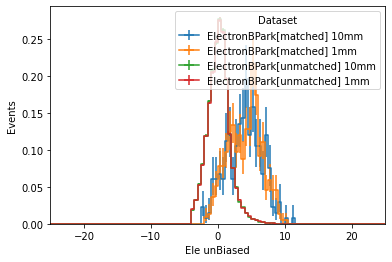

In [75]:
histo_unBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("unBiased", "Ele unBiased", 100, -25, 25),
        )
histo_unBiased.fill(dataset ="ElectronBPark[matched] 1mm", unBiased = cut_pt(matched_eles_1mm).unBiased.flatten())
histo_unBiased.fill(dataset ="ElectronBPark[unmatched] 1mm", unBiased = cut_pt(unmatched_eles_1mm).unBiased.flatten())
histo_unBiased.fill(dataset ="ElectronBPark[matched] 10mm", unBiased = cut_pt(matched_eles_10mm).unBiased.flatten())
histo_unBiased.fill(dataset ="ElectronBPark[unmatched] 10mm", unBiased = cut_pt(unmatched_eles_10mm).unBiased.flatten())
%matplotlib inline
ax_unBiased = hist.plot1d(histo_unBiased, density = True, overflow="over")
ax_unBiased.set_xlim(right=25, left=-25)

(-25.0, 25.0)

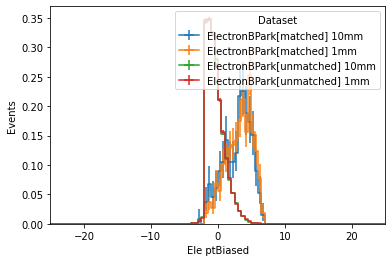

In [76]:
histo_ptBiased = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ptBiased", "Ele ptBiased", 100, -25, 25),
        )
histo_ptBiased.fill(dataset ="ElectronBPark[matched] 1mm", ptBiased = cut_pt(matched_eles_1mm).ptBiased.flatten())
histo_ptBiased.fill(dataset ="ElectronBPark[unmatched] 1mm", ptBiased = cut_pt(unmatched_eles_1mm).ptBiased.flatten())
histo_ptBiased.fill(dataset ="ElectronBPark[matched] 10mm", ptBiased = cut_pt(matched_eles_10mm).ptBiased.flatten())
histo_ptBiased.fill(dataset ="ElectronBPark[unmatched] 10mm", ptBiased = cut_pt(unmatched_eles_10mm).ptBiased.flatten())
%matplotlib inline
ax_ptBiased = hist.plot1d(histo_ptBiased, density = True, overflow="over")
ax_ptBiased.set_xlim(right=25, left=-25)

(0.0, 3.0)

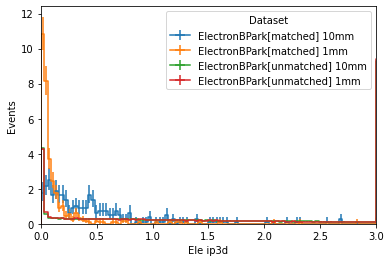

In [78]:
histo_ip3d = hist.Hist(
            "Events",
            hist.Cat("dataset", "Dataset"),
            hist.Bin("ip3d", "Ele ip3d", 100, 0, 3),
        )
histo_ip3d.fill(dataset ="ElectronBPark[matched] 1mm", ip3d = cut_pt(matched_eles_1mm).ip3d.flatten())
histo_ip3d.fill(dataset ="ElectronBPark[unmatched] 1mm", ip3d = cut_pt(unmatched_eles_1mm).ip3d.flatten())
histo_ip3d.fill(dataset ="ElectronBPark[matched] 10mm", ip3d = cut_pt(matched_eles_10mm).ip3d.flatten())
histo_ip3d.fill(dataset ="ElectronBPark[unmatched] 10mm", ip3d = cut_pt(unmatched_eles_10mm).ip3d.flatten())
%matplotlib inline
ax_ip3d = hist.plot1d(histo_ip3d, density = True, overflow="all")
ax_ip3d.set_xlim(right=3, left=0)